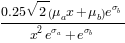

In [1]:
#プロトタイプ
%matplotlib inline
from IPython.display import display
from sympy import *
init_printing()
y,x,ua,ub,sa,sb,x,d = symbols('y,x,mu_a,mu_b,sigma_a,sigma_b,x,d')
f = 0.5 + 0.5 * erf((ua*x+ub)/sqrt(exp(sa)*x*x+exp(sb))/sqrt(2))
p = -exp(-(ua*x+ub)**2/(exp(sa)*x*x+exp(sb))/2)/sqrt(pi)/sqrt(exp(sa)*x*x+exp(sb))
display(simplify(diff(f,sb)/p))

40955

array([[ 0.,  0.,  0.,  0.]])

array([[  9.03005769e-05,   4.02275989e-05,   2.04428342e-03,
          3.37342617e-03]])

40956

array([[ 0.,  0.,  0.,  1.]])

array([[  2.31383056e-05,   1.22575972e-03,   1.54882761e-04,
          9.96808841e-01]])

40957

array([[ 0.,  0.,  1.,  0.]])

array([[  1.16930816e-05,   1.56323154e-03,   9.96947193e-01,
          2.07555871e-05]])

40958

array([[ 0.,  1.,  0.,  0.]])

array([[  2.31329267e-05,   9.99951048e-01,   4.72174471e-04,
          5.68410270e-04]])

40959

array([[ 1.,  0.,  0.,  0.]])

array([[  9.99792045e-01,   7.65762630e-07,   1.34013202e-03,
          1.02490822e-03]])

array([[ 0.99964382,  0.99712323,  0.99295288,  0.9918433 ]])

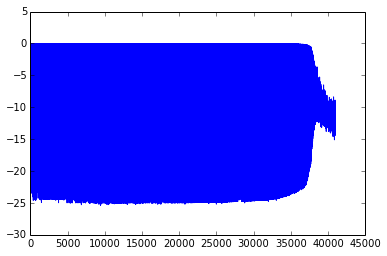

In [521]:
#プロトタイプ 3層
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
from scipy.special import erf, erfc

#I=map(lambda v:transpose(array([v],dtype='float64')),[[1,1,1,1],[1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]])
I=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

r = 1 / 16.0
err = []
eps = 1.0e-240
epoch = 5 * ( 2 ** 13 )

if False:
    HAu = normal(size=(256,4))
    HAv = zeros(shape(HAu))

    HBu = zeros((256,1))
    HBv = zeros(shape(HBu))

    GAu = normal(size=(256,256))
    GAv = zeros(shape(GAu))
    
    GBu = zeros((256,1))
    GBv = zeros(shape(GBu))
    
    OAu = normal(size=(4,256))
    OAv = zeros(shape(OAu))

    OBu = zeros((4,1))
    OBv = zeros(shape(OBu))
    
elif False:
    OAv = OAv * 0.9
    OBv = OBv * 0.9
    GAv *= 0.9
    GBv *= 0.9
    HAv = HAv * 0.9
    HBv = HBv * 0.9
    
def error(J, T, P, Q):
    return J * (T-P)

def delta(J, T, P, Q):
    A = P
    B = Q
    C = T
    D = (1-T)
    E = J*(C/A-D/B)
    NG = logical_or(isnan(E), isinf(E))
    E[NG] = 0
    return E

likelyhood = 1
for k in range(epoch):
    i = k%5#int(uniform(0,5))
    X = I[ i ]
    Y = O[ i ]
    
    #H
    HX = X
    HA = normal(size=shape(HAu))*exp(0.5*HAv)+HAu
    HB = normal(size=shape(HBu))*exp(0.5*HBv)+HBu
    
    HVu = dot(HAu,      HX   ) + HBu
    HVv = dot(exp(HAv), HX**2) + exp(HBv)
    HVs = sqrt(HVv)
    
    HF = (0 < dot(HA, HX) + HB)*(1-2*eps) + eps
    HP = (0.5-2*eps) * erfc(-(-HVu)/HVs/sqrt(2)) + eps
    HQ = (0.5-2*eps) * erfc( (-HVu)/HVs/sqrt(2)) + eps
    
    #G
    GX = HF
    GA = normal(size=shape(GAu))*exp(0.5*GAv)+GAu
    GB = normal(size=shape(GBu))*exp(0.5*GBv)+GBu
    
    GVu = dot(GAu,      GX   ) + GBu
    GVv = dot(exp(GAv), GX**2) + exp(GBv)
    GVs = sqrt(GVv)
    
    GF = (0 < dot(GA, GX) + GB)*(1-2*eps) + eps
    GP = (0.5-2*eps) * erfc(-(-GVu)/GVs/sqrt(2)) + eps
    GQ = (0.5-2*eps) * erfc( (-GVu)/GVs/sqrt(2)) + eps
    
    #O
    OX = GF
    OA = normal(size=shape(OAu))*exp(0.5*OAv)+OAu
    OB = normal(size=shape(OBu))*exp(0.5*OBv)+OBu
    
    OVu = dot(OAu,      OX   ) + OBu
    OVv = dot(exp(OAv), OX**2) + exp(OBv)
    OVs = sqrt(OVv)
    
    OF = (0 < dot(OA, OX) + OB)*(1-eps) + eps
    OP = (0.5-2*eps) * erfc(-(-OVu)/OVs/sqrt(2)) + eps
    OQ = (0.5-2*eps) * erfc( (-OVu)/OVs/sqrt(2)) + eps

    E = Y - OP
    
    #O
    OJ = exp(-(-OVu)**2/OVv/2.0)/sqrt(pi)/OVs/sqrt(2)
    OD = OJ * sign(Y-OF)#delta(OJ, Y, OP, OQ)#    OD = OJ * (OY - OF)
    
    OAu = OAu - r * (OD).dot(OX.T)
    OBu = OBu - r * (OD)
    OAv = OAv + r * (exp(OAv) * ((OD*OVu/OVv).dot(OX.T**2)))
    OBv = OBv + r * (exp(OBv) * ((OD*OVu/OVv)))

    #G
    GJ = exp(-(-GVu)**2/GVv/2.0)/sqrt(pi)/GVs/sqrt(2)
    GD = GJ * sign(dot(OA.T, OD))
    
    GAu = GAu - r * (GD).dot(GX.T)
    GBu = GBu - r * (GD)
    GAv = GAv + r * (exp(GAv) * ((GD*GVu/GVv).dot(GX.T**2)))
    GBv = GBv + r * (exp(GBv) * ((GD*GVu/GVv)))
    
    #H
    HJ = exp(-(-HVu)**2/HVv/2.0)/sqrt(pi)/HVs/sqrt(2)
    HD = HJ * sign(dot(GA.T, GD))
    
    HAu = HAu - r * (HD).dot(HX.T)
    HBu = HBu - r * (HD)
    HAv = HAv + r * (exp(HAv) * ((HD*HVu/HVv).dot(HX.T**2)))
    HBv = HBv + r * (exp(HBv) * ((HD*HVu/HVv)))
    
    err.append(dot(E.T, E)[0])
    if k > epoch - 6:
        likelyhood *= (OP**Y)*((1-OP)**(1-Y))
        display(k, Y.T, OP.T)
        
#display(HAv,HBv,OAs,OBs)
display(likelyhood.T)
figure();plot(log(err))

In [ ]:
#プロトタイプ 3層
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
from scipy.special import erf, erfc

I=map(lambda v:transpose(array([v],dtype='float64')),[[1,1,1,1],[1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]])
#I=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

r = 1 / 16.0
err = []
eps = 1.0e-80
epoch = 5 * ( 2 ** 14 )

if True:
    HAu = normal(size=(16,4))
    HAv = zeros(shape(HAu))

    HBu = zeros((16,1))
    HBv = zeros(shape(HBu))

    GAu = normal(size=(16,16))
    GAv = zeros(shape(GAu))
    
    GBu = zeros((16,1))
    GBv = zeros(shape(GBu))
    
    OAu = normal(size=(4,16))
    OAv = zeros(shape(OAu))

    OBu = zeros((4,1))
    OBv = zeros(shape(OBu))
    
elif False:
    OAv = OAv * 0.9
    OBv = OBv * 0.9
    GAv *= 0.9
    GBv *= 0.9
    HAv = HAv * 0.9
    HBv = HBv * 0.9
    
def error(J, T, P, Q):
    return J * (T-P)

def delta(J, T, P, Q):
    A = P
    B = Q
    C = T
    D = (1-T)
    E = J*(C/A-D/B)
    NG = logical_or(isnan(E), isinf(E))
    E[NG] = 0
    return E

likelyhood = 1
for k in range(epoch):
    i = k%5#int(uniform(0,5))
    X = I[ i ]
    Y = O[ i ]
    
    #H
    HX = X
    HA = normal(size=shape(HAu))*exp(0.5*HAv)+HAu
    HB = normal(size=shape(HBu))*exp(0.5*HBv)+HBu
    
    HVu = dot(HAu,      HX   ) + HBu
    HVv = dot(exp(HAv), HX**2) + exp(HBv)
    HVs = sqrt(HVv)
    
    HF = (0 < dot(HA, HX) + HB)*(1-2*eps) + eps
    HP = (0.5-2*eps) * erfc(-(-HVu)/HVs/sqrt(2)) + eps
    HQ = (0.5-2*eps) * erfc( (-HVu)/HVs/sqrt(2)) + eps
    
    #G
    GX = HF
    GA = normal(size=shape(GAu))*exp(0.5*GAv)+GAu
    GB = normal(size=shape(GBu))*exp(0.5*GBv)+GBu
    
    GVu = dot(GAu,      GX   ) + GBu
    GVv = dot(exp(GAv), GX**2) + exp(GBv)
    GVs = sqrt(GVv)
    
    GF = (0 < dot(GA, GX) + GB)*(1-2*eps) + eps
    GP = (0.5-2*eps) * erfc(-(-GVu)/GVs/sqrt(2)) + eps
    GQ = (0.5-2*eps) * erfc( (-GVu)/GVs/sqrt(2)) + eps
    
    #O
    OX = GF
    OA = normal(size=shape(OAu))*exp(0.5*OAv)+OAu
    OB = normal(size=shape(OBu))*exp(0.5*OBv)+OBu
    
    OVu = dot(OAu,      OX   ) + OBu
    OVv = dot(exp(OAv), OX**2) + exp(OBv)
    OVs = sqrt(OVv)
    
    OF = (0 < dot(OA, OX) + OB)*(1-eps) + eps
    OP = (0.5-2*eps) * erfc(-(-OVu)/OVs/sqrt(2)) + eps
    OQ = (0.5-2*eps) * erfc( (-OVu)/OVs/sqrt(2)) + eps

    E = Y - OP
    
    #O
    OJ = exp(-(-OVu)**2/OVv/2.0)/sqrt(pi)/OVs/sqrt(2)
    OD = delta(OJ, Y, OP, OQ)#    OD = OJ * (OY - OF)
    
    OAu = OAu - r * (OD).dot(OX.T)
    OBu = OBu - r * (OD)
    OAv = OAv + r * (exp(OAv) * ((OD*OVu/OVv).dot(OX.T**2)))
    OBv = OBv + r * (exp(OBv) * ((OD*OVu/OVv)))

    #G
    GJ = exp(-(-GVu)**2/GVv/2.0)/sqrt(pi)/GVs/sqrt(2)
    GD = GJ * sign(dot(OA.T, OD))
    
    GAu = GAu - r * (GD).dot(GX.T)
    GBu = GBu - r * (GD)
    GAv = GAv + r * (exp(GAv) * ((GD*GVu/GVv).dot(GX.T**2)))
    GBv = GBv + r * (exp(GBv) * ((GD*GVu/GVv)))
    
    #H
    HJ = exp(-(-HVu)**2/HVv/2.0)/sqrt(pi)/HVs/sqrt(2)
    HD = HJ * sign(dot(GA.T, GD))
    
    HAu = HAu - r * (HD).dot(HX.T)
    HBu = HBu - r * (HD)
    HAv = HAv + r * (exp(HAv) * ((HD*HVu/HVv).dot(HX.T**2)))
    HBv = HBv + r * (exp(HBv) * ((HD*HVu/HVv)))
    
    err.append(dot(E.T, E)[0])
    if k > epoch - 6:
        likelyhood *= (OP**Y)*((1-OP)**(1-Y))
        display(k, Y.T, OP.T)
    
    HUT[k,0:64] = reshape(HAu,(64))
    HUT[k,64:80] = reshape(HBu,(16))
    HVT[k,0:64] = reshape(HAv,(64))
    HVT[k,64:80] = reshape(HBv,(16))
    
    OUT[k,0:64] = reshape(OAu,(64))
    OUT[k,64:68] = reshape(OBu,(4))
    OVT[k,0:64] = reshape(OAv,(64))
    OVT[k,64:68] = reshape(OBv,(4))
        
#display(HAv,HBv,OAs,OBs)
display(likelyhood.T)
figure();plot(log(err))
figure();plot(HUT)
figure();plot(OUT)
figure();plot(HVT)
figure();plot(OVT)

In [510]:
#プロトタイプ 2層
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
from scipy.special import erf, erfc

#I=map(lambda v:transpose(array([v],dtype='float64')),[[1,1,1,1],[1,1,1,0],[1,1,0,1],[1,0,1,1],[0,1,1,1]])
I=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

r = 1 / 16.0
err = []
eps = 1.0e-80
epoch = 5 * ( 2 ** 11 )

HUT = zeros((epoch,80))
HVT = zeros((epoch,80))

OUT = zeros((epoch,68))
OVT = zeros((epoch,68))

if False:
    HAu = normal(size=(16,4))
    HAv = zeros(shape(HAu))

    HBu = zeros((16,1))
    HBv = zeros(shape(HBu))

    OAu = normal(size=(4,16))
    OAv = zeros(shape(OAu))

    OBu = zeros((4,1))
    OBv = zeros(shape(OBu))
    
elif False:
    OAv = OAv * 0.99 + 1
    OBv = OBv * 0.99 + 1
    HAv = HAv * 0.99 + 1
    HBv = HBv * 0.99 + 1
    
def error(J, T, P, Q):
    return J * (T-P)

def delta(J, T, P, Q):
    A = P
    B = Q
    C = T
    D = (1-T)
    E = J*(C/A-D/B)
    NG = logical_or(isnan(E), isinf(E))
    E[NG] = 0
    return E

likelyhood = 1
for k in range(epoch):
    i = k%5#int(uniform(0,5))
    X = I[ i ]
    Y = O[ i ]
    
    HX = X
    HA = normal(size=shape(HAu))*exp(0.5*HAv)+HAu
    HB = normal(size=shape(HBu))*exp(0.5*HBv)+HBu
    
    HVu = dot(HAu,      HX   ) + HBu
    HVv = dot(exp(HAv), HX**2) + exp(HBv)
    HVs = sqrt(HVv)
    
    HF = (0 < dot(HA, HX) + HB)*(1-2*eps)+eps
    HP = (0.5-2*eps) * erfc(-(-HVu)/HVs/sqrt(2)) + eps
    HQ = (0.5-2*eps) * erfc( (-HVu)/HVs/sqrt(2)) + eps
    
    OX = HF
    OA = normal(size=shape(OAu))*exp(0.5*OAv)+OAu
    OB = normal(size=shape(OBu))*exp(0.5*OBv)+OBu
    
    OVu = dot(OAu,      OX   ) + OBu
    OVv = dot(exp(OAv), OX**2) + exp(OBv)
    OVs = sqrt(OVv)
    
    OF = (0 < dot(OA, OX) + OB)*(1-eps)+eps
    OP = (0.5-2*eps) * erfc(-(-OVu)/OVs/sqrt(2)) + eps
    OQ = (0.5-2*eps) * erfc( (-OVu)/OVs/sqrt(2)) + eps

    E = Y - OP
    
    OY = Y
    OJ = exp(-(-OVu)**2/OVv/2.0)/sqrt(pi)/OVs/sqrt(2)
    OD = delta(OJ, OY, OP, OQ)#    OD = OJ * (OY - OF)
    
    OAu = OAu - r * (OD).dot(OX.T)
    OBu = OBu - r * (OD)
    OAv = OAv + r * (exp(OAv) * ((OD*OVu/OVv).dot(OX.T**2)))
    OBv = OBv + r * (exp(OBv) * ((OD*OVu/OVv)))
    
    HJ = exp(-(-HVu)**2/HVv/2.0)/sqrt(pi)/HVs/sqrt(2)
    HD = HJ * sign(dot(OA.T, OD))
    
    HAu = HAu - r * (HD).dot(HX.T)
    HBu = HBu - r * (HD)
    HAv = HAv + r * (exp(HAv) * ((HD*HVu/HVv).dot(HX.T**2)))
    HBv = HBv + r * (exp(HBv) * ((HD*HVu/HVv)))
    
    err.append(dot(E.T, E)[0])
    if k > epoch - 6:
        likelyhood *= (OP**Y)*((1-OP)**(1-Y))
        display(k, Y.T, OP.T)

#    HAv += 0.5**16
#    HBv += 0.5**16
#    OAv += 0.5**16
#    OBv += 0.5**16
    
    HUT[k,0:64] = reshape(HAu,(64))
    HUT[k,64:80] = reshape(HBu,(16))
    HVT[k,0:64] = reshape(HAv,(64))
    HVT[k,64:80] = reshape(HBv,(16))
    
    OUT[k,0:64] = reshape(OAu,(64))
    OUT[k,64:68] = reshape(OBu,(4))
    OVT[k,0:64] = reshape(OAv,(64))
    OVT[k,64:68] = reshape(OBv,(4))
        
#display(HAv,HBv,OAs,OBs)
display(likelyhood.T)
figure();plot(log(err))
figure();plot(HUT)
figure();plot(OUT)
figure();plot(HVT)
figure();plot(OVT)

ValueError: total size of new array must be unchanged

array([[ 0.,  0.,  0.,  0.]])

array([[  1.23811279e-06,   0.00000000e+00,   6.36004822e-08,
          1.38252724e-07]])

array([[ 0.,  0.,  0.,  1.]])

array([[  1.42093697e-05,   9.82277880e-06,   0.00000000e+00,
          9.99981634e-01]])

array([[ 0.,  0.,  1.,  0.]])

array([[  1.42215063e-05,   9.71117240e-06,   9.99981824e-01,
          0.00000000e+00]])

array([[ 0.,  1.,  0.,  0.]])

array([[  8.27086563e-07,   9.99979668e-01,   2.18300350e-05,
          2.21018542e-05]])

array([[ 1.,  0.,  0.,  0.]])

array([[  9.99980392e-01,   1.31497787e-05,   1.48843199e-05,
          1.50520988e-05]])

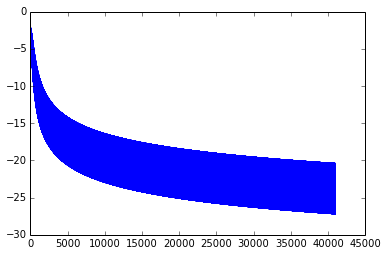

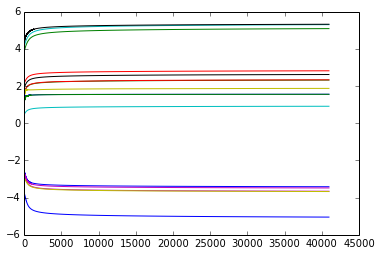

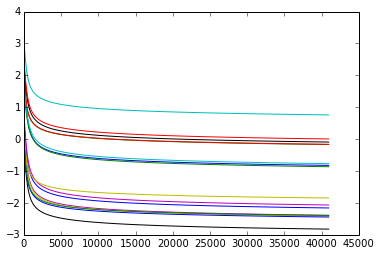

In [483]:
#プロトタイプ 1層
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
from scipy.special import erfc, erf
I=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0  ],[0,0,1  ],[0,1,0  ],[0,1,1  ],[1,0,0  ]])
O=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])

if False:
    WU = normal(size=(4,3))
    WS = ones(shape(WU))
    BU = normal(size=(4,1))
    BS = ones(shape(BU))
elif True:
    WS += pi
    BS += pi

eps = 1/16.0
err = []
epoch = 5 * ( 2 ** 13 )
u = zeros((16,epoch))
s = zeros((16,epoch))

def error(J, D, Y):
    return J * ( D - Y )

def delta(J, D, P, Q):
    E = J
    row, col = shape(J)
    for r in range(row):
        for c in range(col):
            if 0 < P[r,c] and 0 < Q[r,c]:
                #Cross Entropy
                E[r,c] *= D[r,c]/P[r,c] - (1-D[r,c])/Q[r,c]
            else:
                E[r,c] *= 0#D[r,c] - Y[r,c]
    return E

for k in range(epoch):
    X = I[ k % 5 ]
    Y = O[ k % 5 ]
    
    W = normal(size=shape(WU))*exp(0.5*WS)+WU
    B = normal(size=shape(BU))*exp(0.5*BS)+BU
    
    V = dot(W, X) + B
    
    VU = dot(WU,      X   ) + BU
    VV = dot(exp(WS), X**2) + exp(BS)
    VS = sqrt(VV)
    
    F = array(0 < V, dtype='float64')
    P = 0.5 * erfc(-(-VU)/VS/sqrt(2))
    Q = 0.5 * erfc( (-VU)/VS/sqrt(2))
    
    E = (Y - P)
    T = P + eps * E
    J = exp(-(-VU)**2/VV/2.0)/sqrt(pi)/VS/sqrt(2)
    D = delta(J, T, P, Q)
    WU = WU - (D).dot(X.T)
    BU = BU - (D)
    WS = WS + exp(WS) * (D*VU/VV).dot(X.T**2)
    BS = BS + exp(BS) * (D*VU/VV)
    
    err.append(dot(E.T, E)[0])
    u[0:12,k] = reshape(WU, (12))
    u[12:16,k] = reshape(BU, (4))
    s[0:12,k] = reshape(WS, (12))
    s[12:16,k] = reshape(BS, (4))

for k in range(5):
    X = I[k]
    Y = O[k]
    VU = dot(WU,    X   )+BU
    VV = dot(exp(WS), X**2)+exp(BS)
    VS = sqrt(VV)
    P = 0.5 + 0.5 * erf(-VU/VS/sqrt(2))
    display(Y.T, P.T)

figure();plot(log(err))
figure();plot(u.T)
figure();plot(s.T)

In [ ]:
#角層クロスエントロピー
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
I=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v],dtype='float64')),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
HB=normal(0, 0.1, (4, 1))
HW=normal(0, 0.1, (4, 4))
OB=normal(0, 0.1, (4, 1))
OW=normal(0, 0.1, (4, 4))

eps = 0.05
k = 0
r = 8
err = []
for idx in range(2**14):
    k = idx % 5
    Ik = I[k]
    Ok = O[k]
    HO = (0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB)))
    OO = (0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB)))
    
    E = Ok - OO
    err.append(E.T.dot(E)[0])

    #O update
    E = Ok - OO
    C = (Ok)/(OO) - (1-Ok)/(1-OO)
    DB = r * ( 1 - OO * OO ) * C
    DB[isnan(DB)] = 0
    DB[isinf(DB)] = sign(DB[isinf(DB)])
    DX = HO + eps * dot(inv(OW), DB)
    
    DW = dot(DB, transpose(HO))
    OW = OW + eps * DW
    OB = OB + eps * DB

    #H update
    E = DX - HO
    C = (DX)/(HO) - (1-DX)/(1-HO)
    DB = r * ( 1 - HO * HO ) * C
    DB[isnan(DB)] = 0
    DB[isinf(DB)] = sign(DB[isinf(DB)])
    DX = dot(transpose(HW), DB)
    
    DW = dot(DB, transpose(Ik))
    HW = HW + eps * DW
    HB = HB + eps * DB

for k in range(5):
    Ik = I[k]
    Ok = O[k]
    HO = 0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB))
    OO = 0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB))
    display(k, Ik.T, OO.T)

plot(log(err))

In [ ]:
#角層最急降下法
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
I=map(lambda v:transpose(array([v])),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v])),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
HB=normal(0, 1, (16, 1))
HW=normal(0, 1, (16, 4))
OB=normal(0, 1, (4,  1))
OW=normal(0, 1, (4, 16))

eps = 0.05
k = 0
r = 8
err = []
for idx in range(2**16):
    k = idx % 5
    Ik = I[k]
    Ok = O[k]
    HO = (0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB)))# > uniform(0, 1, (16, 1))
    OO = (0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB)))# > uniform(0, 1, (4, 1))

    E = Ok - OO
    err.append(E.T.dot(E)[0])

    #O update
    DB = r * ( 1 - OO * OO ) * ( Ok - OO )
    DX = dot(transpose(OW), Ok)
    
    OW = OW + eps * dot(DB, transpose(HO))
    OB = OB + eps * DB

    #H update
    DB = r * ( 1 - HO * HO ) * ( DX - HO )
    DX = dot(transpose(HW), DB)
    
    DW = dot(DB, transpose(Ik))
    HW = HW + eps * DW
    HB = HB + eps * DB

for k in range(5):
    Ik = I[k]
    Ok = O[k]
    HO = 0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB))
    OO = 0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB))
    display(k, Ik.T, OO.T)

plot(log(err))

In [ ]:
#ただの最急降下法
%matplotlib inline
from IPython.display import display
from matplotlib.pylab import *
I=map(lambda v:transpose(array([v])),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,0,1,1],[0,1,0,0]])
O=map(lambda v:transpose(array([v])),[[0,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0],[1,0,0,0]])
HB=normal(0, 1, (16, 1))
HW=normal(0, 1, (16, 4))
OB=normal(0, 1, (4,  1))
OW=normal(0, 1, (4, 16))

eps = 0.01
k = 0
r = 8
err = []
for idx in range(2**16):
    k = idx % 5
    Ik = I[k]
    Ok = O[k]
    HO = (0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB)))# > uniform(0, 1, (16, 1))
    OO = (0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB)))# > uniform(0, 1, (4, 1))

    DX = Ok - OO
    E = Ok - OO
    err.append(E.T.dot(E)[0])

    #O update
    DB = DX * r * (1 - OO * OO)
    DX = dot(transpose(OW), DB)
    
    OW = OW + eps * dot(DB, transpose(HO))
    OB = OB + eps * DB

    #H update
    DB = DX * r * (1 - HO * HO)
    DX = dot(transpose(HW), DB)
    
    DW = dot(DB, transpose(Ik))
    HW = HW + eps * DW
    HB = HB + eps * DB

for k in range(5):
    Ik = I[k]
    Ok = O[k]
    HO = 0.5 + 0.5 * tanh(r*(dot(HW, Ik)+HB))
    OO = 0.5 + 0.5 * tanh(r*(dot(OW, HO)+OB))
    display(k, Ik.T, OO.T)
    
plot(log(err))

In [49]:
display(erfcx(16),erfc(16)*exp(16*16),erfc(-2**20))

0.035193377824930837

0.035193377824930844

2.0

In [ ]:
from sympy import *
d,y=symbols('d,y')
solve(d*(1-y)-y*(1-d),y)